In [2]:
import numpy as np

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)

# Vlasov-Poisson equation
We consider the dimensionless Vlasov-Poisson equation for one species
with a neutralizing background.

$$ 
\frac{\partial f}{\partial t}+ v\cdot \nabla_x f + E(t,x) \cdot \nabla_v f = 0, \\
- \Delta \phi = 1 - \rho, E = - \nabla \phi \\
\rho(t,x)  =  \int f(t,x,v)dv.
$$





# Landau Damping

In [2]:
%load_ext cython

AttributeError: module 'cython' has no attribute '__file__'

In [3]:
%%cython
import cython
import numpy as np
cimport numpy as np
ctypedef np.float64_t dtype_t      # shorthand type. easy to change
cdef double bspline(int p, int j, double x):
        """Return the value at x in [0,1[ of the B-spline with 
        integer nodes of degree p with support starting at j.
        Implemented recursively using the de Boor's recursion formula"""
        cdef double w
        cdef double w1
        assert ((x >= 0.0) & (x <= 1.0))
        assert ((type(p) == int) & (type(j) == int))
        if p == 0:
            if j == 0:
                return 1.0
            else:
                return 0.0
        else:
            w = (x - j) / p
            w1 = (x - j - 1) / p
        return w * bspline(p - 1, j, x) + (1 - w1) * bspline(p - 1, j + 1, x)

class BSpline:
    
    def __init__(self, p, xmin, xmax, ncells):
        assert p & 1 == 1  # check that p is odd
        self.p = p
        self.ncells = ncells
        # compute eigenvalues of degree p b-spline matrix
        self.modes = 2 * np.pi * np.arange(ncells) / ncells
        self.deltax = (xmax - xmin) / ncells
        
        self.eig_bspl = bspline(p, -(p + 1) // 2, 0.0)
        for j in range(1, (p + 1) // 2):
            self.eig_bspl += bspline(p, j - (p + 1) // 2, 0.0) * 2 * np.cos(j * self.modes)
            
        self.eigalpha = np.zeros(ncells, dtype=complex)
    
    def interpolate_disp(self, np.ndarray[dtype_t, ndim=1] f, double alpha):
        """compute the interpolating spline of degree p of odd degree 
        of a function f on a periodic uniform mesh, at
        all points xi-alpha"""
        cdef int p
        cdef int ishift
        cdef double beta
        cdef Py_ssize_t j
        p = self.p
        assert (np.size(f) == self.ncells)
        # compute eigenvalues of cubic splines evaluated at displaced points
        ishift = np.floor(-alpha / self.deltax)
        beta = -ishift - alpha / self.deltax
        self.eigalpha.fill(0.)
        for j in range(-(p - 1) // 2, (p + 1) // 2 + 1):
            self.eigalpha += bspline(p, j - (p + 1) // 2, beta) * np.exp((ishift + j) * 1j * self.modes)
            
        # compute interpolating spline using fft and properties of circulant matrices
        return np.real(np.fft.ifft(np.fft.fft(f) * self.eigalpha / self.eig_bspl))


ERROR:root:Cell magic `%%cython` not found.


In [4]:
n =100
cs = BSpline(3,0,1,n)
x = np.linspace(0,1,n, endpoint=False)
f = np.sin(x*4*np.pi)
alpha = 0.2
plt.plot( x, np.sin((x-alpha)*4*np.pi), 'r-', x, cs.interpolate_disp(f, alpha),'bo');

NameError: name 'BSpline' is not defined

In [5]:
class EricVlasovPoisson:
    
    def __init__(self, xmin, xmax, nx, vmin, vmax, nv, f = None):
        
        self.nx = nx
        self.x, self.dx = np.linspace(xmin, xmax, nx, endpoint=False, retstep=True )
        self.nv = nv
        self.v, self.dv = np.linspace(vmin, vmax, nv, endpoint=False, retstep=True)

        if f is not None : 
            self.f = f
        else:
            self.f = np.zeros((nx,nv))
            
        self.cs_x = BSpline(3, xmin, xmax, nx)
        self.cs_v = BSpline(3, vmin, vmax, nv)
        self.modes = 2 * np.pi * (np.arange(nx / 2 + 1)) / (xmax - xmin)
        self.modes[0] = 1.  # avoid division by 0
        self.xmin = xmin
        self.xmax = xmax
        self.vmin = vmin
        self.vmax = vmax
        
    def advection_x(self, dt):
        for j in range(self.nv):
            alpha = dt * self.v[j]
            self.f[:,j] = self.cs_x.interpolate_disp(self.f[:,j], alpha)
            
    def advection_v(self, e, dt):
        for i in range(self.nx):
            alpha = dt * e[i] 
            self.f[i,:] = self.cs_v.interpolate_disp(self.f[i,:], alpha)
            
    def compute_rho(self):
        return  self.dv * np.sum(self.f, axis=1)
            
    def compute_e(self, rho):
        # compute Ex using that ik*Ex = rho
        rhok = np.fft.rfft(rho)
        return np.fft.irfft(-1j*rhok/self.modes)

In [6]:
%%time
sim = EricVlasovPoisson(xmin = 0.0, xmax = 4*np.pi, nx = 100,
             vmin = -6., vmax = 6., nv = 100)

X, V = np.meshgrid(sim.x, sim.v)
eps = 0.05
kx  = 0.5 
sim.f = (1.0+eps*np.cos(kx*X))/(2.0*np.pi)* np.exp(-0.5*V*V)

nstep = 500

t, dt = np.linspace(0.0, 10.0, nstep, retstep=True)
nrj = []
print("dt = {}".format(dt))

sim.advection_x(0.5*dt)
for istep in range(nstep):
    rho = sim.compute_rho()
    e = sim.compute_e(rho)
    sim.advection_v(e, dt)
    sim.advection_x(dt)
    nrj.append( 0.5*np.log(np.sum(e*e)*sim.dx))
    if (istep % 100 == 0 ): print(istep,end=',')

plt.plot(t, nrj)

NameError: name 'np' is not defined

NameError: name 'X' is not defined

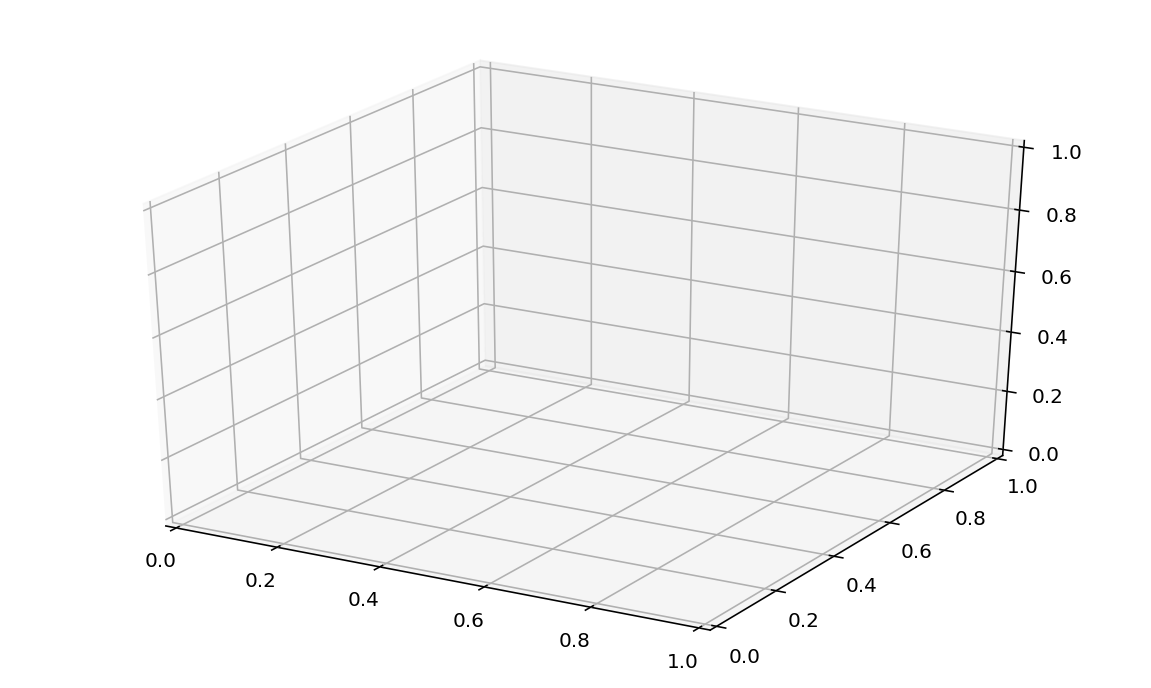

In [7]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, V, sim.f, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


In [111]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np

n = 4
f = np.arange(n*n).reshape(n,n)
v = np.arange(n)
print(f)
def add( f1d, inc ):
    return f1d + inc

e = ThreadPoolExecutor(4)

tasks = [e.submit(add, f[i,:], v[i]) for i in range(n)]
for i,t in enumerate(tasks):
    f[i,:] = t.result()

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
